In [1]:
import numpy as np 
import pandas as pd 
import os

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Dense, MaxPooling2D,Conv2D,Input,UpSampling2D, Flatten, Reshape
from tensorflow.keras.layers import BatchNormalization, Dropout, Lambda, Conv2DTranspose, Layer, LeakyReLU
from tensorflow.keras.losses import binary_crossentropy, sparse_categorical_crossentropy
from tensorflow.keras.models import Model
from keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1
import keras.backend as K
import tensorflow as tf
#from tensorflow.keras import metrics
from keras.models import Sequential
from sklearn.metrics import f1_score, classification_report
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from tqdm import tqdm
import random
# to ignore displaying warnings
import warnings
warnings.filterwarnings("ignore")

2022-08-20 15:57:17.608899: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-20 15:57:17.608936: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os

In [3]:
train_path = "../../data/chest_xray/train"
val_path = "../../data/chest_xray/val"
test_path = "../../data/chest_xray/test"

anomaly_path = "../../data/chest_xray/PN_test_copy/"

In [4]:
def displayer(X_tr, X_tr_ae):
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(1, n + 1):
        # Display original
        ax = plt.subplot(2, n, i)
        plt.imshow(X_tr[i].reshape(64, 64, 3))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstruction
        ax = plt.subplot(2, n, i + n)
        plt.imshow(X_tr_ae[i].reshape(64, 64,3))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [5]:
dsize =(64, 64)

labels = {"NORMAL":0, "PNEUMONIA":1}

In [6]:
def load_images(dir_path, labels, dsize = (32, 32)):
    """loading images"""
    X_image, y_image = [], []
    for label_name, Id in labels.items():
        for jpeg in tqdm(os.listdir(os.path.join(dir_path, label_name))):
            path = os.path.join(dir_path, label_name, jpeg)
            image = load_img(path, target_size=dsize)
            X_image.append(image)
            #self.X_image.append(img_to_array(image)/255.0)
            y_image.append(Id)
    return X_image, y_image

def display_images(X, y, figure_row=4, figure_cols=4):
    """Display images """
    f, ax = plt.subplots(nrows= figure_row, ncols=figure_cols, 
                         figsize=(figure_row*figure_cols, figure_row*figure_cols)) 
    number_of_images = figure_row * figure_cols
    img = []
    for i in range(figure_row):
        for j in range(figure_cols):
            while True:
                rand = np.random.randint(0, len(X)-1)
                if rand not in img:
                    img.append(rand)
                    break
            image=X[rand]#cv2.imread(self.path_lsts[rand])
            ax[i, j].imshow(image, resample=True, cmap='gray')
            ax[i, j].set_title("Class-"+ str(y[rand]), fontsize=16)
    plt.tight_layout()
    plt.show()
    print

In [7]:
X_train_org, y_train = load_images(train_path, labels, dsize = dsize)

X_val_org, y_val = load_images(val_path, labels, dsize = dsize)

X_test_org, y_test = load_images(test_path, labels, dsize = dsize)

anomaly_org, y_anomaly = load_images(anomaly_path, labels, dsize = dsize)

100%|██████████| 1341/1341 [00:14<00:00, 91.95it/s] 
0it [00:00, ?it/s]
100%|██████████| 8/8 [00:00<00:00, 159.32it/s]
0it [00:00, ?it/s]
100%|██████████| 234/234 [00:01<00:00, 155.15it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 390/390 [00:00<00:00, 433.05it/s]


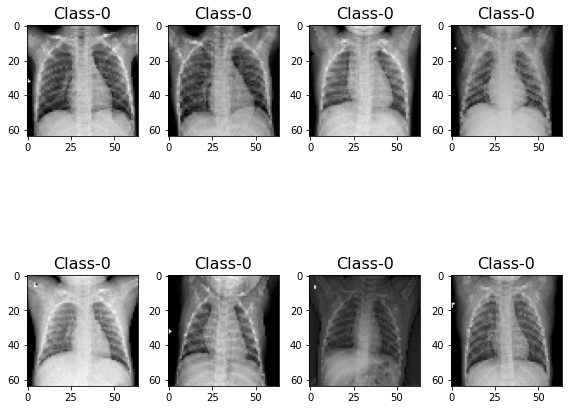

In [8]:
display_images(X_train_org, y_train, figure_row=2, figure_cols=4)

In [9]:
def preprocess_images(images, y, normalize = True):
    X = []
    for i in tqdm(range(len(images))):
        img = img_to_array(images[i]).astype('float32')
        if normalize:
            img = img/255.0
        X.append(img)
    #Shuffle data
    dataset = list(zip(X, y))
    random.shuffle(dataset)

    X, y = zip(*dataset)
    return np.array(X), np.array(y)

In [10]:
normalize = True

x_train, y_train =preprocess_images(X_train_org, y_train, normalize=normalize)
print("Shape of X_train:", x_train.shape)

x_val, y_val =preprocess_images(X_val_org, y_val, normalize=normalize)
print("Shape of X_val:", x_val.shape)

x_test, y_test =preprocess_images(X_test_org, y_test, normalize=normalize)
print("Shape of X_test:", x_test.shape)

anomaly, y_anomaly =preprocess_images(anomaly_org, y_anomaly, normalize=normalize)
print("Shape of anomy:", anomaly.shape)

100%|██████████| 1341/1341 [00:00<00:00, 21322.04it/s]


Shape of X_train: (1341, 64, 64, 3)


100%|██████████| 8/8 [00:00<00:00, 10747.74it/s]


Shape of X_val: (8, 64, 64, 3)


100%|██████████| 234/234 [00:00<00:00, 30631.60it/s]


Shape of X_test: (234, 64, 64, 3)


100%|██████████| 390/390 [00:00<00:00, 31955.67it/s]

Shape of anomy: (390, 64, 64, 3)


In [11]:
def CNNUAE(input_shape):
    input_img = Input(shape=input_shape)

    x = Conv2D(32, (8, 8), activation='relu', padding='same')(input_img)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    
    x = Conv2D(16, (8, 8), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    
    x = Conv2D(8, (8, 8), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)
    
    x = Conv2D(8, (8, 8), activation='relu', padding='same')(encoded)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)
    
    x = Conv2D(16, (8, 8), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)
    
    x = Conv2D(32, (8, 8), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)
    
    decoded = Conv2D(3, (8, 8), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    return autoencoder

In [12]:
cnnuae_autoencoder = CNNUAE(x_train[0].shape)
cnnuae_autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        6176      
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 16)        32784     
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 16)       64    

2022-08-20 15:58:20.318690: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-08-20 15:58:20.318717: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (iotg): /proc/driver/nvidia/version does not exist
2022-08-20 15:58:20.318972: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
%%time
history = cnnuae_autoencoder.fit(x_train, x_train, epochs=5, batch_size=64,
                    shuffle=True, validation_data=(x_val, x_val))

Epoch 1/5
21/21 [==============================] - 20s 924ms/step - loss: 0.0341 - val_loss: 0.0848
Epoch 2/5
21/21 [==============================] - 19s 896ms/step - loss: 0.0146 - val_loss: 0.0680
Epoch 3/5
21/21 [==============================] - 19s 896ms/step - loss: 0.0117 - val_loss: 0.0452
Epoch 4/5
21/21 [==============================] - 19s 902ms/step - loss: 0.0103 - val_loss: 0.0401
Epoch 5/5
21/21 [==============================] - 19s 887ms/step - loss: 0.0093 - val_loss: 0.0360
CPU times: user 12min 52s, sys: 28.5 s, total: 13min 21s
Wall time: 1min 35s


In [14]:
test_x_predictions = cnnuae_autoencoder.predict(x_test)

8/8 [==============================] - 0s 36ms/step


In [15]:
mse_normal_errors = []

for i in range(len(x_test)):
    mse = np.mean(np.mean(np.square(x_test[i] - test_x_predictions[i]), axis=1))
    mse_normal_errors.append(mse)
        

In [16]:
test_anomaly_predictions = cnnuae_autoencoder.predict(anomaly)

13/13 [==============================] - 1s 39ms/step


In [17]:
mse_pneumonia_errors = []

for i in range(len(x_test)):
    mse = np.mean(np.mean(np.square(anomaly[i] - test_anomaly_predictions[i]), axis=1))
    mse_pneumonia_errors.append(mse)


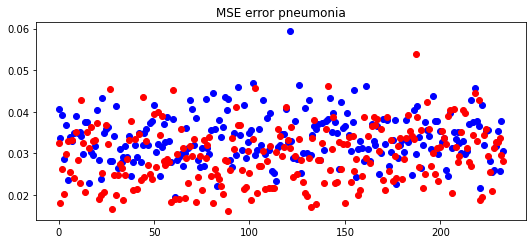

In [18]:
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

plt.title("MSE error pneumonia")
plt.plot(mse_normal_errors, 'bo')
plt.plot(mse_pneumonia_errors, 'ro')

plt.show()

In [19]:
np.mean(mse_normal_errors), np.mean(mse_pneumonia_errors)

(0.03364545, 0.029541506)